<h1 align="center">Demand Forecasting for a Retail Store</h1>
<h3 align="center">#CC69852</h3>

## Importing the required libraries and the required dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_csv('C:/Users/naiks/Downloads/shampoo.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   36 non-null     object 
 1   Sales   36 non-null     float64
dtypes: float64(1), object(1)
memory usage: 708.0+ bytes


In [2]:
# Create a proper datetime index
df['Month'] = pd.to_datetime(df['Month'].str.split('-').apply(lambda x: f"{2020 + int(x[0])}-{x[1]}"))

# Set the datetime index
df.set_index('Month', inplace=True)

## Exploratory Data Analysis (EDA)

In [3]:
# Display basic statistics
print("Basic Statistics:")
print(df.describe())

Basic Statistics:
            Sales
count   36.000000
mean   312.600000
std    148.937164
min    119.300000
25%    192.450000
50%    280.150000
75%    411.100000
max    682.000000


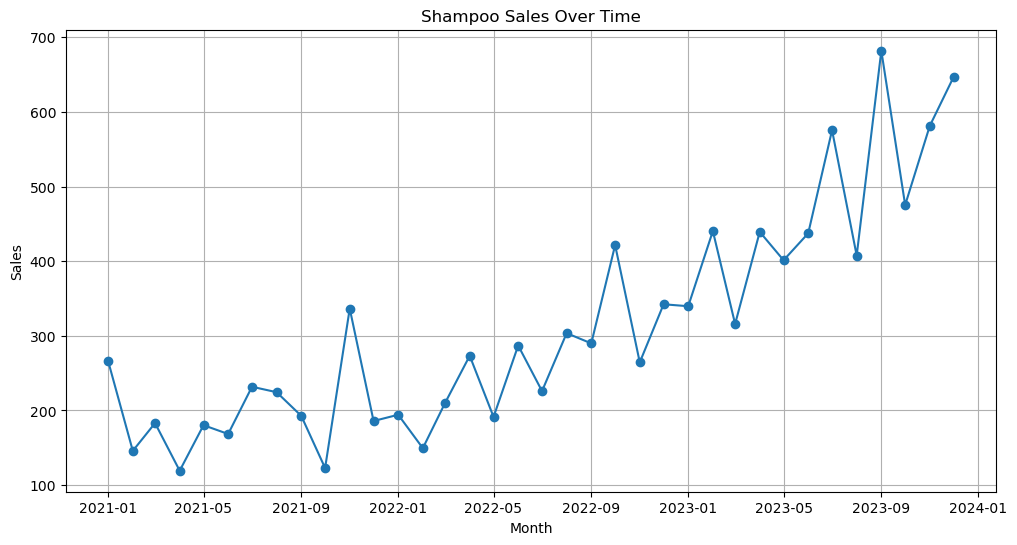

In [4]:
# Visualize the time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], marker='o', linestyle='-')
plt.title('Shampoo Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

C:\Users\naiks\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


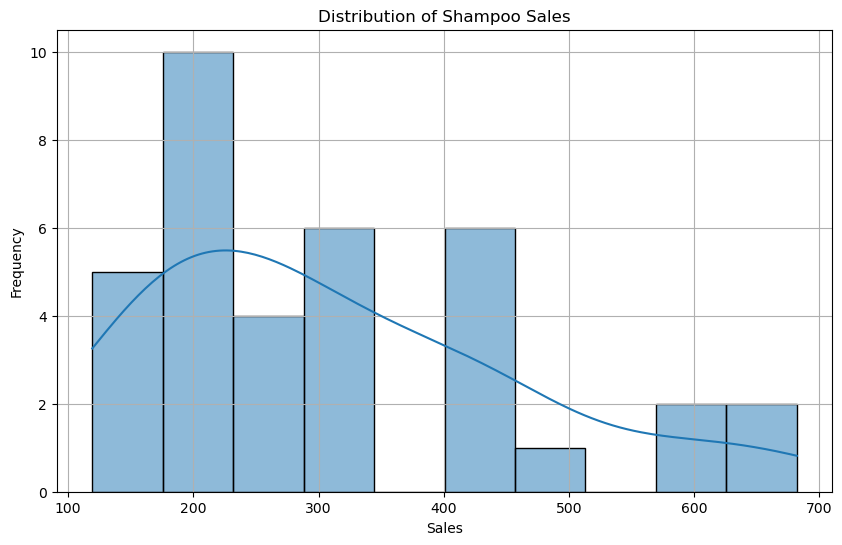

In [5]:
import seaborn as sns

# Visualize sales distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Sales'], bins=10, kde=True)
plt.title('Distribution of Shampoo Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

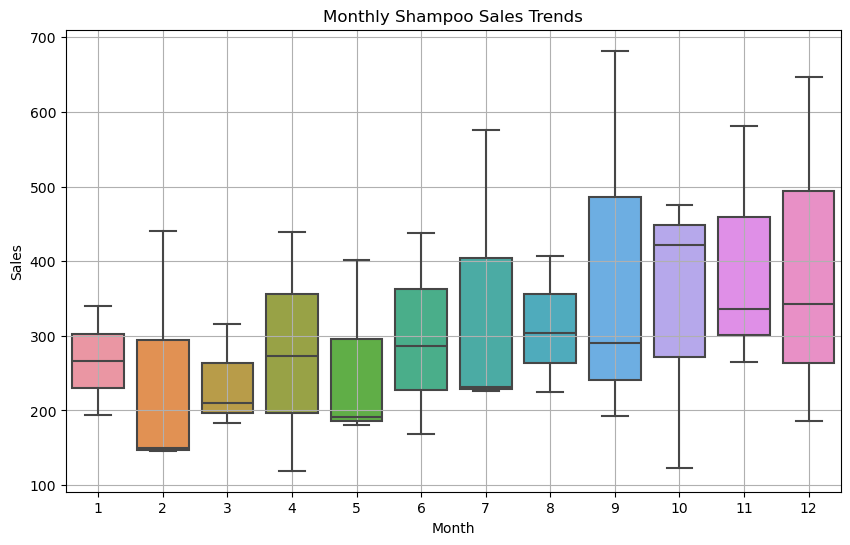

In [6]:
# Visualize monthly sales trends
plt.figure(figsize=(10, 6))
sns.boxplot(x=df.index.month, y='Sales', data=df)
plt.title('Monthly Shampoo Sales Trends')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

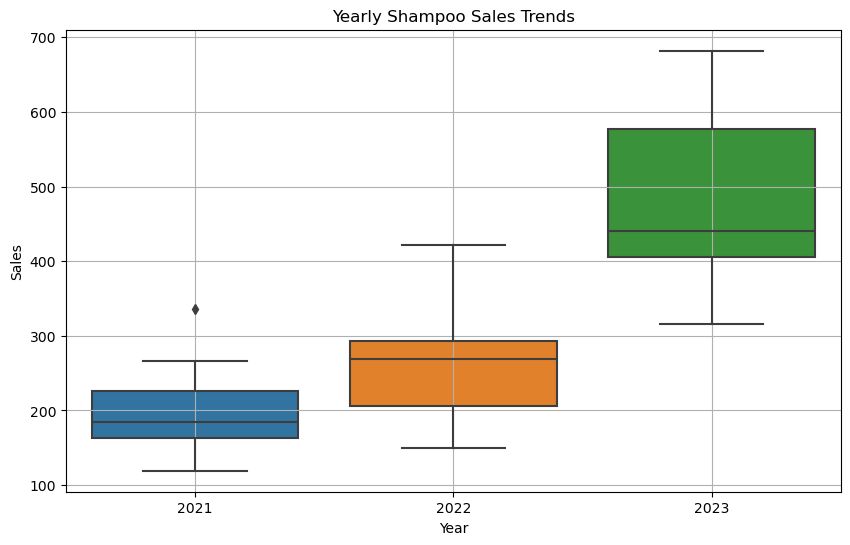

In [7]:
# Visualize yearly sales trends
plt.figure(figsize=(10, 6))
sns.boxplot(x=df.index.year, y='Sales', data=df)
plt.title('Yearly Shampoo Sales Trends')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

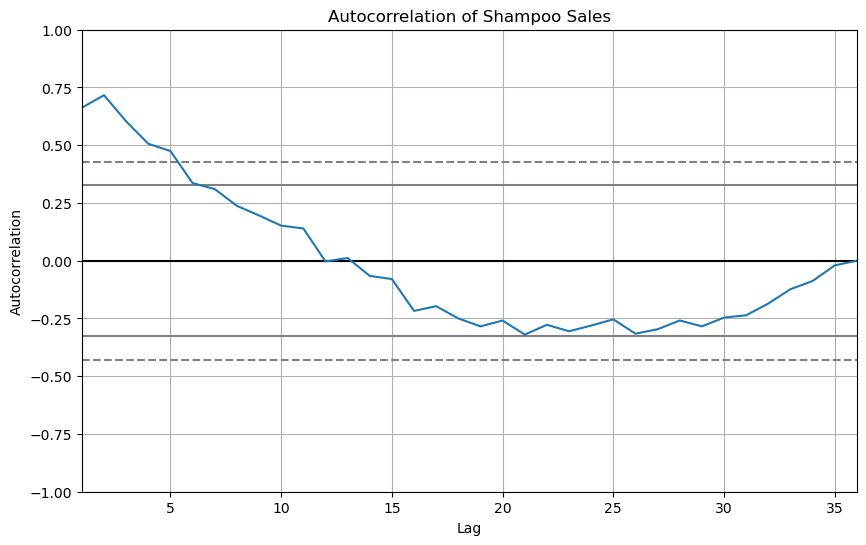

In [8]:
# Visualize autocorrelation
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(df['Sales'])
plt.title('Autocorrelation of Shampoo Sales')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

In [9]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(df['Sales'])

ADF Test Statistic : 3.060142083641183
p-value : 1.0
#Lags Used : 10
Number of Observations : 25
weak evidence against null hypothesis,indicating it is non-stationary 


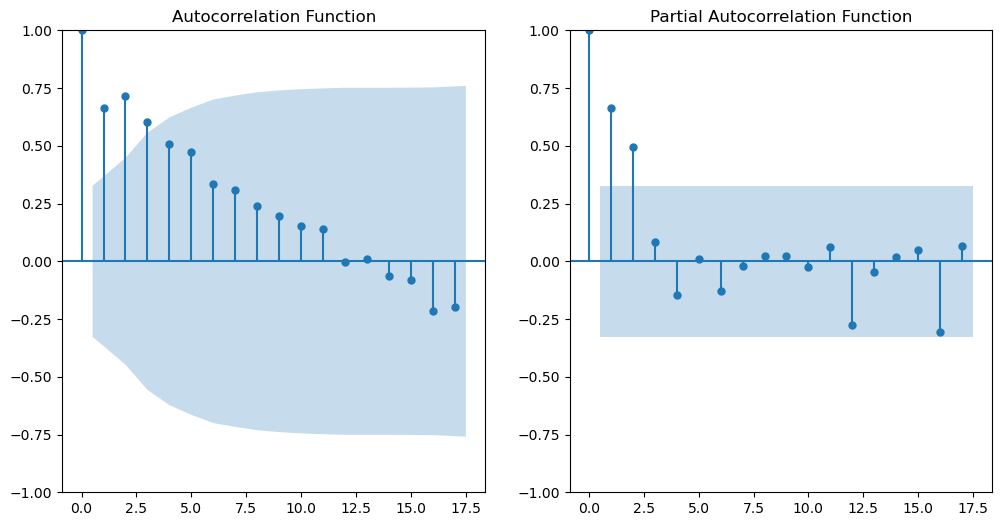

In [10]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(df['Sales'], lags=17, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(df['Sales'], lags=17, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.show()

## Model Buidling & Evaluation

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
train = df[:-12]
test = df[-12:]

In [12]:
# Fit the ARIMA model (initial guess for p, d, q)
model = ARIMA(train['Sales'], order=(1, 1, 1))
model_fit = model.fit()

C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [13]:
# Forecast the sales
forecast = model_fit.forecast(steps=12)
forecast = pd.Series(forecast, index=test.index)

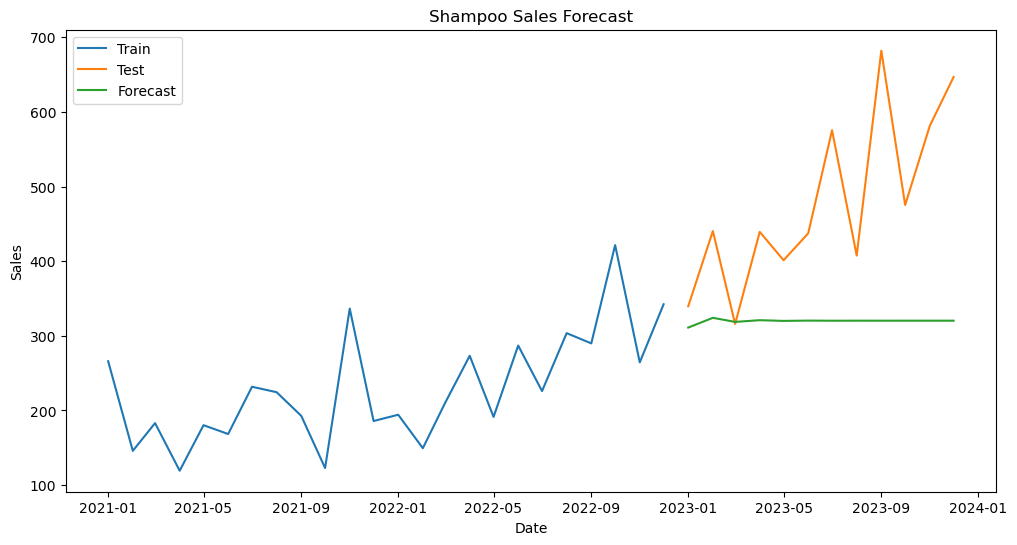

In [14]:
# Plot the forecast against actual sales
plt.figure(figsize=(12, 6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(forecast, label='Forecast')
plt.title('Shampoo Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [15]:
# Evaluate the model
rmse = mean_squared_error(test['Sales'], forecast, squared=False)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 193.8752839645216


In [16]:
import itertools

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Use grid search to find the optimal parameters
best_rmse = float('inf')
best_order = None

for param in pdq:
    try:
        model = ARIMA(train['Sales'], order=param, seasonal_order=(0,1,2,11))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=12)
        rmse = mean_squared_error(test['Sales'], forecast, squared=False)
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = param
    except:
        continue

# Fit the best ARIMA model
best_model = ARIMA(train['Sales'], order=best_order, seasonal_order=(0,1,2,11))
best_model_fit = best_model.fit()

# Forecast the sales using the best model
best_forecast = best_model_fit.forecast(steps=12)
best_forecast = pd.Series(best_forecast, index=test.index)

C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueW

In [17]:
print(f'Best ARIMA order: {best_order} with RMSE: {best_rmse}')

Best ARIMA order: (2, 2, 2) with RMSE: 87.79675179025318


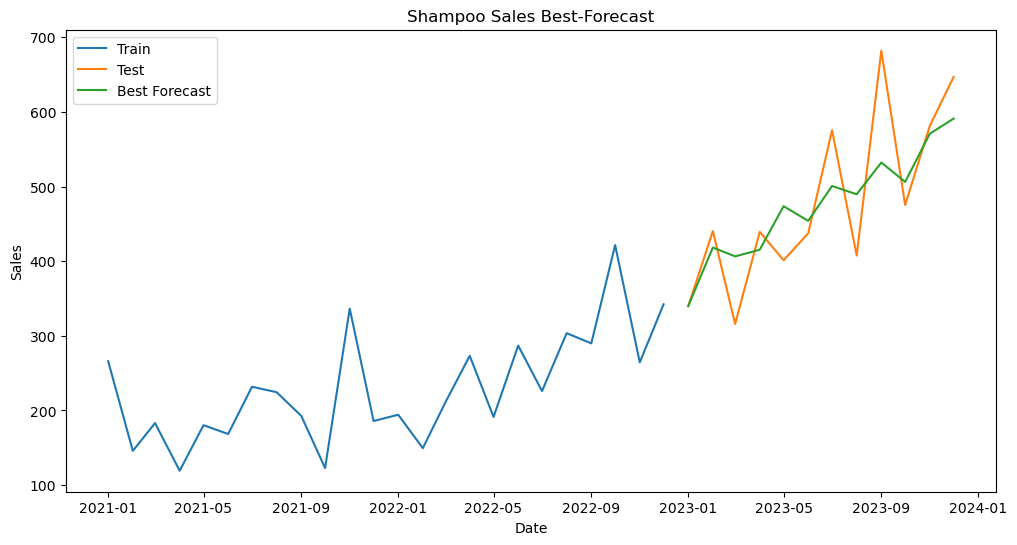

In [30]:
# Plot the best forecast against actual sales
plt.figure(figsize=(12, 6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(best_forecast, label='Best Forecast')
plt.title('Shampoo Sales Best-Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [31]:
best_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   24
Model:             SARIMAX(0, 2, 2)x(2, 0, 2, 12)   Log Likelihood                -124.441
Date:                            Sat, 01 Jun 2024   AIC                            262.883
Time:                                    22:49:07   BIC                            270.520
Sample:                                01-01-2021   HQIC                           264.682
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9171     18.880     -0.102      0.919     -38.922      35.088
ma.L2          0.9969     19.559      0.051      0.959     -37.338      39.332
ar.S.L12       0.9070   4118.208      0.000      1.000   -8070.633    8072.447
ar.S.L24      -0.1583   2065.924  -7.66e-05      1.000   -4049.294    4048.977
ma.S.L12      -1.6975   5065.654     -0.000      1.000   -9930.196    9926.802
ma.S.L24       0.9880    472.113      0.002      0.998    -924.337     926.313
sigma2      2265.0059      0.101   2.24e+04      0.000    2264.808    2265.204
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.47   Prob(JB):                         0.99
Heteroskedasticity (H):               1.66   Skew:                            -0.08
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.57e+23. Standard errors may be unstable.
"""

C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\naiks\anaconda3\Lib\site-packages\statsmodels\base\

<Axes: xlabel='Month'>

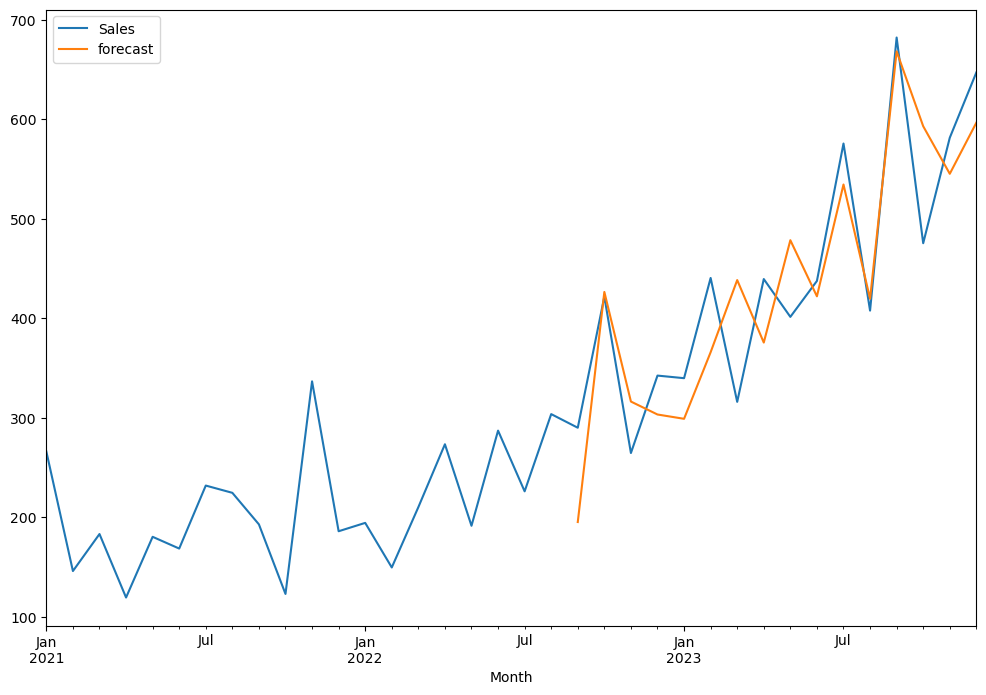

In [32]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(2, 2, 2),seasonal_order=(0,1,2,11))
results=model.fit()
df['forecast']=results.predict(start=20,end=36,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

C:\Users\naiks\AppData\Local\Temp\ipykernel_17428\466682643.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df,future_datest_df])


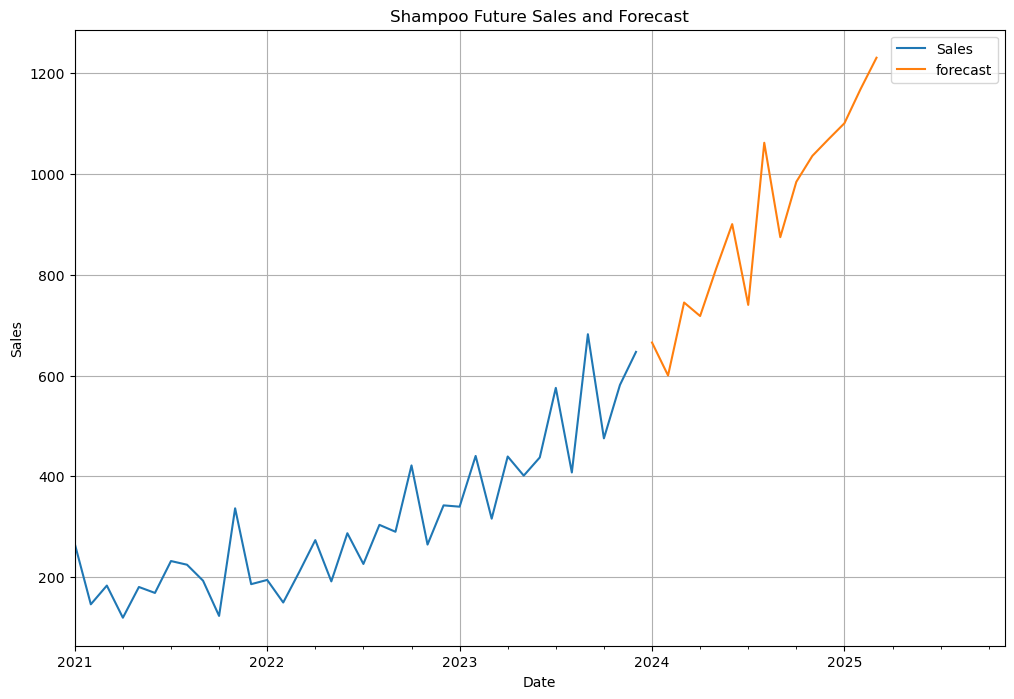

In [33]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()
future_df=pd.concat([df,future_datest_df])
future_df['forecast'] = results.predict(start = 36, end = 50, dynamic= True)
future_df[['Sales', 'forecast']].plot(figsize=(12, 8))
plt.title('Shampoo Future Sales and Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()